In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<center>
<span style="color:crimson; font-size:42px;"> Tuberculosis (TB) Chest X-ray Database </span>
</center>    

<center>
<span style="color:crimson; font-size:25px;"> InceptionV3 Model</span>
</center>  

![istockphoto-1195893424-612x612.jpeg](attachment:9f141e8d-8522-4c12-9d7d-d5fa55c67294.jpeg)

# <span style="color:blue; font-family:monospace;"> Import libraries </span>

In [ ]:
# necessary libraries
import os
import pandas as pd

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

# <span style="color:blue; font-family:monospace;"> Explore Dataset </span>

In [ ]:
base_dir= "/content/drive/MyDrive/tuberculosis/TB_Chest_Radiography_Database"
os.listdir(base_dir)

['Normal.metadata.xlsx',
 'README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Tuberculosis',
 'Normal']

In [ ]:
tuberculosis_data= "/content/drive/MyDrive/tuberculosis/TB_Chest_Radiography_Database/Tuberculosis"
print("tuberculosis images :\n" ,os.listdir(tuberculosis_data)[:5])

normal_data= "/content/drive/MyDrive/tuberculosis/TB_Chest_Radiography_Database/Normal"
print("\nnormal images :\n" ,os.listdir(normal_data)[:5])

tuberculosis images :
 ['Tuberculosis-134.png', 'Tuberculosis-130.png', 'Tuberculosis-142.png', 'Tuberculosis-109.png', 'Tuberculosis-15.png']

normal images :
 ['Normal-3300.png', 'Normal-3233.png', 'Normal-3259.png', 'Normal-3323.png', 'Normal-3328.png']


In [ ]:
print("no. of tuberculosis images :" ,len(os.listdir(tuberculosis_data)))
print("\nno. of normal images :" ,len(os.listdir(normal_data)))

no. of tuberculosis images : 700

no. of normal images : 3500


### <span style="color:blue; font-family:monospace;"> Let's have a look at the images </span>

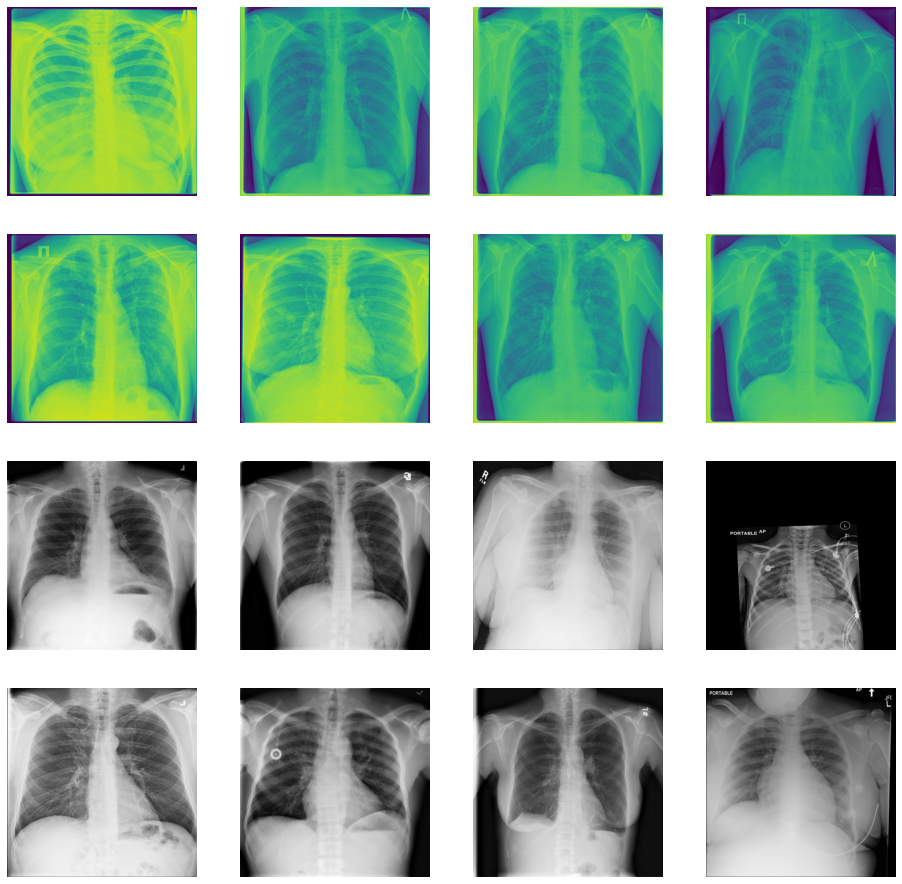

In [ ]:
nrows= 4
ncols= 4
pic_index= 0

fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)

plt.show()

In [ ]:
image= imread("/content/drive/MyDrive/tuberculosis/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-107.png")
image.shape

(512, 512)

# <span style="color:blue; font-family:monospace;"> Generating Train and Validation set using Data Augmentation </span>

In [ ]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 3360 images belonging to 2 classes.

validation data :
Found 840 images belonging to 2 classes.


### <span style="color:blue; font-family:monospace;"> Class Labels </span>

In [ ]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

# <span style="color:blue; font-family:monospace;"> Model Building </span>

## <span style="color:blue; font-family:monospace;"> Transfer Learning- InceptionV3 Model</span>

In [ ]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception_model= InceptionV3(input_shape= (300, 300,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception_model.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
pretrained_model= Model(inception_model.input, last_output)    

In [ ]:
pretrained_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

## <span style="color:blue; font-family:monospace;">Creating Dense Layers </span>

In [ ]:
# layer 1
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
model3= Model(pretrained_model.input, x)

model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# compile model


from tensorflow.keras import optimizers
model3.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again. 
# So we will freeze these layers
# for layer in pretrained_model.layers:
#     layer.trainable= False

# model fitting
history= model3.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=2 
                  )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
168/168 - 914s - loss: 0.1927 - accuracy: 0.9548 - val_loss: 1.3012 - val_accuracy: 0.8917 - 914s/epoch - 5s/step
Epoch 2/10
168/168 - 138s - loss: 0.0757 - accuracy: 0.9860 - val_loss: 0.6396 - val_accuracy: 0.9774 - 138s/epoch - 821ms/step
Epoch 3/10
168/168 - 132s - loss: 0.0829 - accuracy: 0.9866 - val_loss: 29.5905 - val_accuracy: 0.9036 - 132s/epoch - 784ms/step
Epoch 4/10
168/168 - 131s - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.6707 - val_accuracy: 0.9155 - 131s/epoch - 778ms/step
Epoch 5/10
168/168 - 130s - loss: 0.0445 - accuracy: 0.9908 - val_loss: 0.3228 - val_accuracy: 0.9845 - 130s/epoch - 775ms/step
Epoch 6/10
168/168 - 130s - loss: 0.0442 - accuracy: 0.9914 - val_loss: 0.1246 - val_accuracy: 0.9905 - 130s/epoch - 775ms/step
Epoch 7/10
168/168 - 130s - loss: 0.1342 - accuracy: 0.9896 - val_loss: 0.0961 - val_accuracy: 0.9690 - 130s/epoch - 775ms/step
Epoch 8/10
168/168 - 131s - loss: 0.0263 - accuracy: 0.9923 - val_loss: 0.0612 - val_accuracy: 0.9940 - 13

In [ ]:
# model_1= Sequential()

# model_1.add(Conv2D(filters= 16, kernel_size=(3,3), activation="relu", input_shape=(300, 300, 3)))
# model_1.add(MaxPooling2D(pool_size=(2,2)))

# model_1.add(Conv2D(filters= 32, kernel_size=(3,3), activation="relu"))
# model_1.add(MaxPooling2D(pool_size=(2,2)))

# model_1.add(Conv2D(filters= 64, kernel_size=(3,3), activation="relu"))
# model_1.add(MaxPooling2D(pool_size=(2,2)))

# model_1.add(Conv2D(filters= 128, kernel_size=(3,3), activation="relu"))
# model_1.add(MaxPooling2D(pool_size=(2,2)))

# model_1.add(Flatten())
# model_1.add(Dense(units= 512, activation='relu'))
# model_1.add(Dropout(0.2))

# model_1.add(Dense(units=1, activation="sigmoid"))

# model_1.summary()

In [ ]:
# # model compiling
# model_1.compile(loss= "binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

# history= model_1.fit(train_data,
#                    steps_per_epoch= train_data.samples//train_data.batch_size,
#                    validation_data= val_data,
#                    validation_steps= val_data.samples//val_data.batch_size,
#                    epochs= 10,
#                    verbose=2 
#                   )

# <span style="color:blue; font-family:monospace;"> Model Evaluation</span>

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

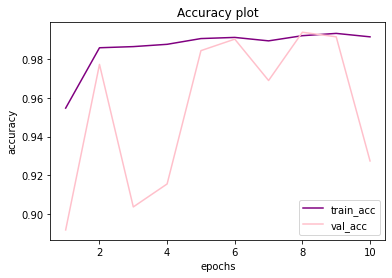

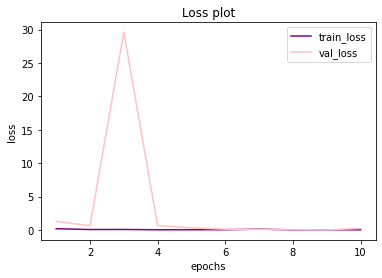

In [ ]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

## <span style="color:blue; font-family:monospace;"> Checking Model Performance</span>

In [ ]:
prediction = model3.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction = (prediction > 0.5)
prediction

42/42 - 25s - 25s/epoch - 585ms/step


array([[False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [

In [ ]:
val_labels=val_data.classes
val_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
prediction.shape

(840, 1)

In [ ]:
val_labels.shape

(840,)

0.9392857142857143
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       700
           1       0.73      1.00      0.85       140

    accuracy                           0.94       840
   macro avg       0.87      0.96      0.90       840
weighted avg       0.96      0.94      0.94       840



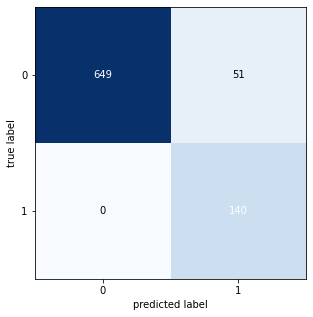

In [ ]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))

In [ ]:
model3.save("/content/drive/MyDrive/tuberculosis1.h5")